In [1]:
import os
import json

import torch

from xstnn import xSpatioTemporalNN
from utils import rmse
from datasets import dataset_factory

import matplotlib.pyplot as plt
%matplotlib inline

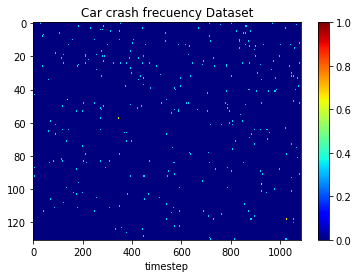

In [2]:
datadir = 'data'
dataset = 'crash'
_, (train_data, test_data), _ , _ = dataset_factory(datadir, dataset)

plt.figure('Car crash frecuency Dataset')
plt.imshow(torch.cat((train_data, test_data)).squeeze().numpy().T, aspect='auto', cmap='jet')
plt.title('Car crash frecuency Dataset')
plt.xlabel('timestep')
plt.colorbar()

In [3]:
run train_xstnn.py --dataset crash --outputdir output_crash --manualSeed 2021 --xp xstnn --nepoch 10000

  7%|▋         | 713/10000 [14:48<3:15:18,  1.26s/it, loss=1.22e-5, rmse_test=0.0261] 

<Figure size 432x288 with 0 Axes>

In [4]:
outputdir  = 'output_crash'
exps = ['xstnn']
models = {}
for exp in exps:
    with open(os.path.join(outputdir, exp, 'config.json'), 'r') as f:
        config = json.load(f)
    setup, (train_data, test_data), relations, (exogenous_train, exogenous_test) = dataset_factory(datadir, dataset, config['khop'])

    model = xSpatioTemporalNN(relations, exogenous_train, 131, 1080, 8, 1, config['nz'], config['mode'], config['nhid'],
                             config['nlayers'], config['dropout_f'], config['dropout_d'],
                             config['activation'], config['periode'])
    state_dict = torch.load(os.path.join(outputdir, exp, 'model.pt'), map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)
    models[exp] = model

In [5]:
predictions  = {}
for exp in exps:
    model = models[exp]
    model.eval()
    with torch.no_grad():
        prediction, _ = model.generate(5, exogenous_train)
        predictions[exp] = prediction
        mse =  rmse(prediction, test_data)
    print('RMSE {}:\t'.format(exp), mse)

RMSE xstnn:	 0.02604258991777897


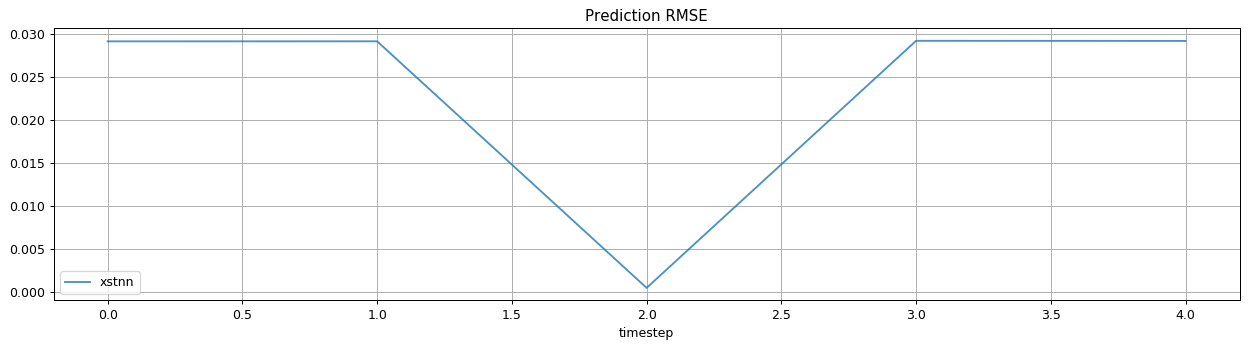

In [6]:
plt.figure('Test plots', figsize=(17, 4), dpi=90)
for exp in exps:
    with open(os.path.join(outputdir, exp, 'logs.json'), 'r') as f:
        logs = json.load(f)

    plt.plot([logs['test_epoch.ts.{}.rmse'.format(ts)][-1] for ts in range(5)], label=exp, alpha=0.8)

plt.grid()
plt.title('Prediction RMSE')
plt.xlabel('timestep')
plt.legend()

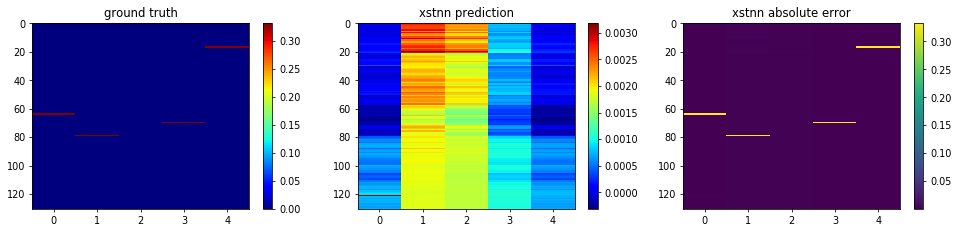

In [7]:
plt.figure('Results', figsize=(17, 12), dpi=70)

plt.subplot(3, 3, 1)
plt.imshow(test_data.squeeze().numpy().T, aspect='auto', cmap='jet')
plt.colorbar()
plt.title('ground truth')

for i, exp in enumerate(exps):
    plt.subplot(3, 3, i * 3 + 2 + i // 3)
    plt.imshow(predictions[exp].squeeze().numpy().T, aspect='auto', cmap='jet')
    plt.colorbar()
    plt.title('{} prediction'.format(exp))

    plt.subplot(3, 3, i * 3 + 3 + i // 3)
    plt.imshow(test_data.sub(predictions[exp]).abs().squeeze().numpy().T, aspect='auto')
    plt.colorbar()
    plt.title('{} absolute error'.format(exp))
    
#plt.savefig('resultados2.png' ,dpi = 400)